In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
# select categorical features
categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [7]:
# select numerical features
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [8]:
data = df.copy()

In [9]:
data[categorical] = data[categorical].fillna('NA')

In [10]:
data[numerical] = data[numerical].fillna(0.0)

In [11]:
data.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [12]:
# First split: train (60%) and temp (40%)
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=1)

# Second split: val (20%) and test (20%) from temp (which is 40% of original)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

# Check the sizes
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 877, Val: 292, Test: 293


In [13]:
# Remove the target column from each split to get features
X_train = train_data.drop(columns=['converted'])
X_val = val_data.drop(columns=['converted'])
X_test = test_data.drop(columns=['converted'])

# Extract the target column from each split
y_train = train_data['converted']
y_val = val_data['converted']
y_test = test_data['converted']

### Q1

In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
for col in [col for col in numerical if col not in ['converted']]:
    score = roc_auc_score(y_train, X_train[col])
    print (f"{col}: {score}")

number_of_courses_viewed: 0.7652439024390244
annual_income: 0.5446354552990968
interaction_count: 0.7271914132379249
lead_score: 0.6111168681007025


### Q2

In [16]:
from sklearn.feature_extraction import DictVectorizer

In [17]:
dv = DictVectorizer(sparse=False)

In [18]:
# convert dataframes to list-of-dicts (exclude target column already removed)
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')
test_dicts = X_test.to_dict(orient='records')

In [19]:
# fit on train, transform all splits
X_train_dv = dv.fit_transform(train_dicts)
X_val_dv = dv.transform(val_dicts)
X_test_dv = dv.transform(test_dicts)

In [20]:
# get feature names (compat fallback)
try:
    feature_names = dv.get_feature_names_out()
except AttributeError:
    feature_names = dv.get_feature_names()

In [21]:
# convert back to DataFrame to keep column names and indices
X_train_transformed_df = pd.DataFrame(X_train_dv, columns=feature_names, index=X_train.index)
X_val_transformed_df   = pd.DataFrame(X_val_dv,   columns=feature_names, index=X_val.index)
X_test_transformed_df  = pd.DataFrame(X_test_dv,  columns=feature_names, index=X_test.index)

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [24]:
model.fit(X_train_transformed_df, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [25]:
preds_val = model.predict(X_val_transformed_df)

In [26]:
auc_val = roc_auc_score(y_val, preds_val)
print(f"Validation AUC: {auc_val:.3f}")

Validation AUC: 0.691


### Q3

In [27]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

In [28]:
probs_val = model.predict_proba(X_val_transformed_df)[:, 1]

In [29]:
scores = {'thresholds': [], 'precision': [], 'recall': []}
for val in np.arange(0.0, 1.0, 0.01):
    preds_val = (probs_val >= val).astype(int)
    precision = precision_score(y_val, preds_val)
    recall = recall_score(y_val, preds_val)
    scores['thresholds'].append(val)
    scores['precision'].append(precision)
    scores['recall'].append(recall)

c:\Users\AntonioDias\Documents\ds_projects\deep_learning\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
import matplotlib.pyplot as plt

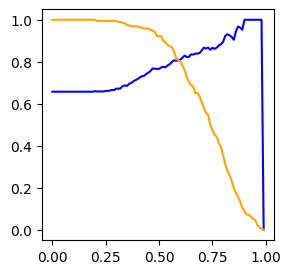

In [31]:
plt.figure(figsize=(3, 3))
plt.plot(scores['thresholds'], scores['precision'], label='Precision', color='blue')
plt.plot(scores['thresholds'], scores['recall'], label='Recall', color='orange')

### Q4

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_scores = {'thresholds': [], 'f1': []}
for val in np.arange(0.0, 1.0, 0.01):
    preds_val = (probs_val >= val).astype(int)
    score = f1_score(y_val, preds_val)
    f1_scores['thresholds'].append(val)
    f1_scores['f1'].append(score)

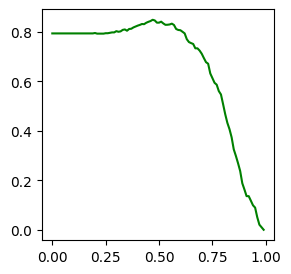

In [34]:
plt.figure(figsize=(3, 3))
plt.plot(f1_scores['thresholds'], f1_scores['f1'], label='F1 Score', color='green')

In [35]:
df_f1scores = pd.DataFrame(f1_scores)

In [36]:
df_f1scores.sort_values(by='f1', ascending=False).head()

,thresholds,f1
47,0.47,0.848485
48,0.48,0.845794
46,0.46,0.843318
51,0.51,0.840855
45,0.45,0.840183


### Q5

In [37]:
from sklearn.model_selection import KFold

In [38]:
df_full_train = pd.concat([X_train_transformed_df, X_val_transformed_df])
y_full_train = pd.concat([y_train, y_val])

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [40]:
auc_scores = []
for train_index, val_index in kf.split(df_full_train):  
    X_train, X_test = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
    y_train, y_test = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    auc_scores.append(auc)
    print(f"AUC: {auc:.3f}")

AUC: 0.807
AUC: 0.807
AUC: 0.865
AUC: 0.833
AUC: 0.815


In [41]:
import numpy as np
np.std(auc_scores)

np.float64(0.021986552473681004)

### Q6

In [42]:
auc_scores_c = {}
for c in [0.000001, 0.001, 1]:
    auc_scores_c[c] = []
    for train_index, val_index in kf.split(df_full_train):  
        X_train, X_test = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
        y_train, y_test = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
        
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=1)
        model.fit(X_train, y_train)
        
        probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
        auc_scores_c[c].append(auc)
    print(f"C={c} Mean AUC: {np.mean(auc_scores_c[c]):.3f} Std: {np.std(auc_scores_c[c]):.3f}")

C=1e-06 Mean AUC: 0.543 Std: 0.025
C=0.001 Mean AUC: 0.864 Std: 0.014
C=1 Mean AUC: 0.825 Std: 0.022
